In [ ]:
#import packages
import pandas as pd
import numpy as np
import string
import re
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import pickle

from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from matplotlib.pyplot import savefig, title
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

# import my custom library into colab
import sys
sys.path.append('/content/gdrive/MyDrive/Github/capstone/')
import mylibrary as mylib

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Github/capstone

/content/gdrive/My Drive/Github/capstone


In [ ]:
# Load train and test pickles
X_train = pd.read_pickle('data/X_train_2class.pkl')
X_test = pd.read_pickle('data/X_test_2class.pkl')
y_train = pd.read_pickle('data/y_train_2class.pkl')
y_test = pd.read_pickle('data/y_test_2class.pkl')

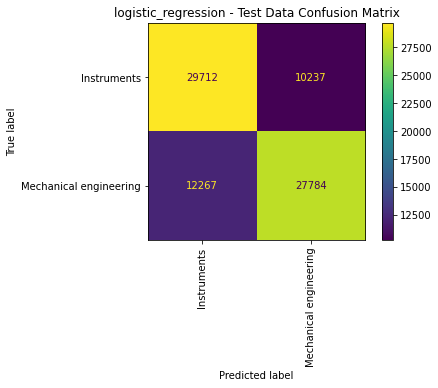

In [ ]:
# Initiate the model
logreg = LogisticRegression(random_state=42, n_jobs=1, 
                            max_iter=200)

# Train and evaluate model
logreg_scores = mylib.model_scores(logreg, 'logistic_regression',
                                   X_train, X_test, 
                                   y_train, y_test)

# Pickle model for later use
pickle.dump(logreg, open('/content/gdrive/MyDrive/Github/capstone/data/model_logreg.pkl', 'wb'))

In [ ]:
logreg_scores

,train_accuracy,test_accuracy,train_recall,test_recall,train_f1,test_f1
logistic_regression,0.716778,0.7187,0.743276,0.743748,0.724153,0.72532


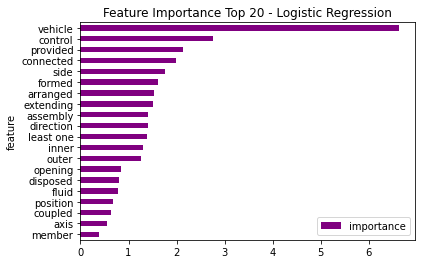

In [ ]:
# get importance
feature_names = X_train.columns

# create dataframe of top features
feature_importance = pd.DataFrame(feature_names, columns = ['feature'])
feature_importance['importance'] = logreg.coef_[0]
feature_importance = feature_importance.sort_values(by = ['importance'], 
                                                    ascending=False)

# plot importance
n = 20
ax = feature_importance.iloc[:n].plot.barh(x='feature', y='importance', 
                                           color='purple').invert_yaxis()
plt.title(f'Feature Importance Top {n} - Logistic Regression')
savefig(f'images/feature_importance_logreg.png', bbox_inches='tight', dpi=300)

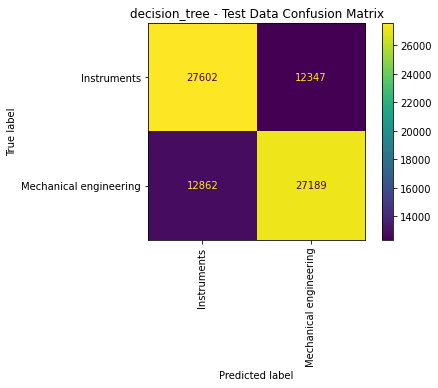

In [ ]:
# Initiate the model
dt = DecisionTreeClassifier(random_state=42)  

# Train and evaluate model
dt_scores = mylib.model_scores(dt, 'decision_tree',
                                   X_train, X_test, 
                                   y_train, y_test)

# Pickle model for later use
pickle.dump(dt, open('/content/gdrive/MyDrive/Github/capstone/data/model_dt.pkl', 'wb'))

In [ ]:
dt_scores

,train_accuracy,test_accuracy,train_recall,test_recall,train_f1,test_f1
decision_tree,0.993556,0.684887,0.998269,0.690931,0.993589,0.686506


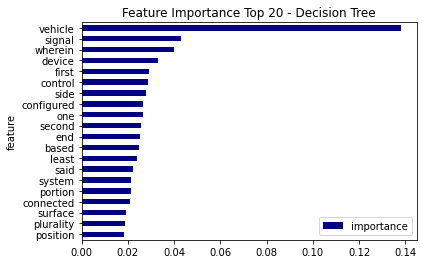

In [ ]:
# get importance
feature_names = X_train.columns

# create dataframe of top features
feature_importance = pd.DataFrame(feature_names, columns = ['feature'])
feature_importance['importance'] = dt.feature_importances_
feature_importance = feature_importance.sort_values(by = ['importance'], 
                                                    ascending=False)

# plot importance
n = 20
ax = feature_importance.iloc[:n].plot.barh(x='feature', y='importance', 
                                           color='navy').invert_yaxis()
plt.title(f'Feature Importance Top {n} - Decision Tree')
savefig(f'images/feature_importance_dt.png', bbox_inches='tight', dpi=300)

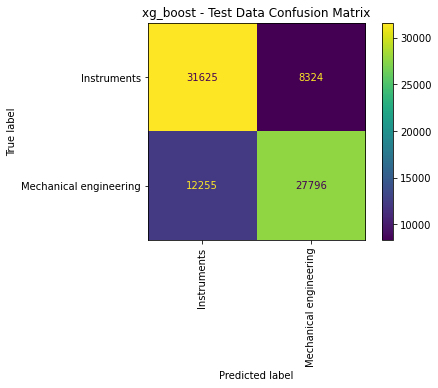

In [ ]:
# Initiate the model
xgb = XGBClassifier(random_state=42)

# Train and evaluate model
xgb_scores = mylib.model_scores(xgb, 'xg_boost',
                                   X_train, X_test, 
                                   y_train, y_test)

# Pickle model for later use
pickle.dump(xgb, open('/content/gdrive/MyDrive/Github/capstone/data/model_xgb.pkl', 'wb'))

In [ ]:
xgb_scores

,train_accuracy,test_accuracy,train_recall,test_recall,train_f1,test_f1
xg_boost,0.742072,0.742762,0.791204,0.791634,0.75421,0.754512


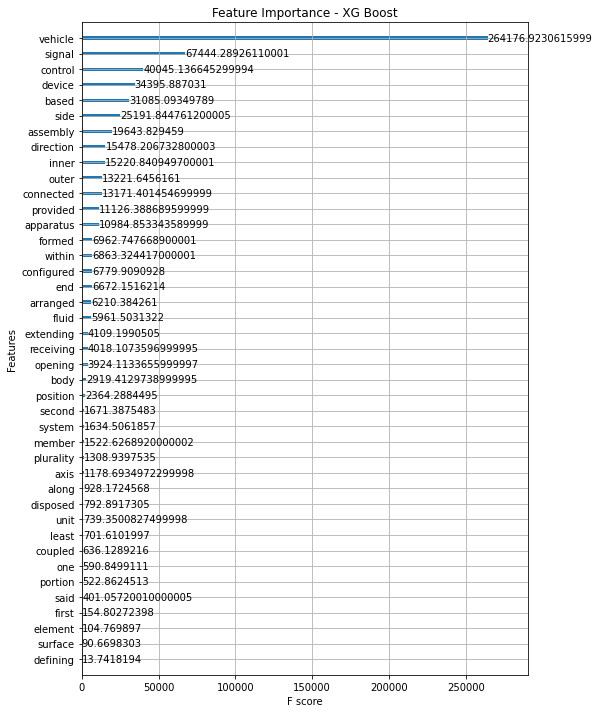

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot feature importance
ax = plot_importance(xgb, importance_type='total_gain')
plt.title('Feature Importance - XG Boost')
fig = ax.figure
fig.set_size_inches(8, 12)
plt.show()
savefig(f'images/feature_importance_xgb.png', bbox_inches='tight', dpi=300)

In [ ]:
scores = pd.concat([logreg_scores, dt_scores, xgb_scores])
scores

,train_accuracy,test_accuracy,train_recall,test_recall,train_f1,test_f1
logistic_regression,0.716778,0.718700,0.743276,0.743748,0.724153,0.725320
decision_tree,0.993556,0.684887,0.998269,0.690931,0.993589,0.686506
xg_boost,0.742072,0.742762,0.791204,0.791634,0.754210,0.754512


In [ ]:
# define parameters to search
params_xgb = {
    'booster':['gbtree', 'gblinear'],
    'max_delta_step ':[100, 10, 1, 0.1],
    'max_depth':[8]
    }

# run grid search
xgb_gs = mylib.run_grid_search(params_xgb, xgb, X_train, y_train)

Grid Search found the following optimal parameters: 
booster: 'gbtree'
max_delta_step : 100
max_depth: 8


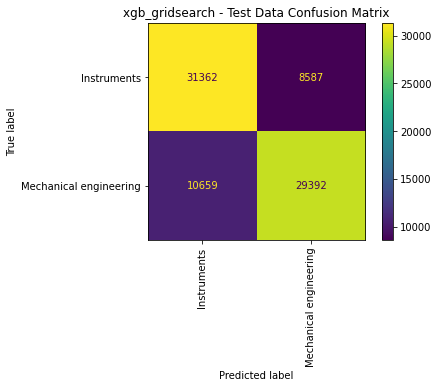

In [ ]:
# Evaluate model
xbg_gs_scores = mylib.model_scores(xgb_gs, 'xgb_gridsearch',
             X_train, X_test, 
             y_train, y_test)

# Pickle model for later use
pickle.dump(xgb_gs, open('/content/gdrive/MyDrive/Github/capstone/data/model_gs_xgb_2class.pkl', 'wb'))

In [ ]:
xbg_gs_scores

,train_accuracy,test_accuracy,train_recall,test_recall,train_f1,test_f1
xgb_gridsearch,0.782078,0.759425,0.809736,0.785051,0.787996,0.765207
